1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

In [1]:
# Import libraries

import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass

In [2]:
# Input password to connect to database

password = getpass.getpass()

 ········


In [3]:
# Establish connection

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [4]:
# Query

query = '''SELECT 
    F.FILM_ID, 
    F.TITLE,
    F.LENGTH, 
    F.RENTAL_RATE AS "RENTAL_PRICE", 
    C.NAME AS "CATEGORY",
    COALESCE(I.NUMBER_OF_COPIES, 0) AS "NUMBER_OF_COPIES",
    COALESCE(R.TIMES_RENTED_IN_MAY, 0) AS "TIMES_RENTED_IN_MAY"
FROM 
    SAKILA.FILM AS F
LEFT JOIN (
    SELECT 
        I.FILM_ID,
        COUNT(DISTINCT I.INVENTORY_ID) AS NUMBER_OF_COPIES
    FROM 
        SAKILA.INVENTORY AS I
    GROUP BY 
        I.FILM_ID
) AS I ON F.FILM_ID = I.FILM_ID
LEFT JOIN (
    SELECT 
        I.FILM_ID,
        COUNT(DISTINCT R.RENTAL_ID) AS TIMES_RENTED_IN_MAY
    FROM 
        SAKILA.RENTAL AS R
    JOIN 
        SAKILA.INVENTORY AS I ON R.INVENTORY_ID = I.INVENTORY_ID
    WHERE 
        EXTRACT(YEAR FROM R.RENTAL_DATE) = 2005 AND EXTRACT(MONTH FROM R.RENTAL_DATE) = 5
    GROUP BY 
        I.FILM_ID
) AS R ON F.FILM_ID = R.FILM_ID
LEFT JOIN SAKILA.FILM_CATEGORY AS FC ON FC.FILM_ID = F.FILM_ID
LEFT JOIN SAKILA.CATEGORY AS C ON FC.CATEGORY_ID = C.CATEGORY_ID;'''

In [5]:
# Get the data

film_data = pd.read_sql_query(query, engine)
display(film_data)

,FILM_ID,TITLE,LENGTH,RENTAL_PRICE,CATEGORY,NUMBER_OF_COPIES,TIMES_RENTED_IN_MAY
0,1,ACADEMY DINOSAUR,86,0.99,Documentary,8,2
1,2,ACE GOLDFINGER,48,4.99,Horror,3,0
2,3,ADAPTATION HOLES,50,2.99,Documentary,4,1
3,4,AFFAIR PREJUDICE,117,2.99,Horror,7,2
4,5,AFRICAN EGG,130,2.99,Family,3,1
...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,183,0.99,Documentary,2,0
996,997,YOUTH KICK,179,0.99,Music,2,0
997,998,ZHIVAGO CORE,105,0.99,Horror,2,1
998,999,ZOOLANDER FICTION,101,2.99,Children,5,1


2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [6]:
# Create new column with boolean expression

film_data['RENTED_IN_MAY'] = film_data['TIMES_RENTED_IN_MAY'] > 0

3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [7]:
# Read data in Pandas dataframe

display(film_data)

,FILM_ID,TITLE,LENGTH,RENTAL_PRICE,CATEGORY,NUMBER_OF_COPIES,TIMES_RENTED_IN_MAY,RENTED_IN_MAY
0,1,ACADEMY DINOSAUR,86,0.99,Documentary,8,2,True
1,2,ACE GOLDFINGER,48,4.99,Horror,3,0,False
2,3,ADAPTATION HOLES,50,2.99,Documentary,4,1,True
3,4,AFFAIR PREJUDICE,117,2.99,Horror,7,2,True
4,5,AFRICAN EGG,130,2.99,Family,3,1,True
...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,183,0.99,Documentary,2,0,False
996,997,YOUTH KICK,179,0.99,Music,2,0,False
997,998,ZHIVAGO CORE,105,0.99,Horror,2,1,True
998,999,ZOOLANDER FICTION,101,2.99,Children,5,1,True


In [8]:
# Remove columns FILM_ID and TITLE as they don't add anything to our analysis

columns_to_drop = ['FILM_ID', 'TITLE']
film_data_final = film_data.drop(columns = columns_to_drop)
display(film_data_final)

,LENGTH,RENTAL_PRICE,CATEGORY,NUMBER_OF_COPIES,TIMES_RENTED_IN_MAY,RENTED_IN_MAY
0,86,0.99,Documentary,8,2,True
1,48,4.99,Horror,3,0,False
2,50,2.99,Documentary,4,1,True
3,117,2.99,Horror,7,2,True
4,130,2.99,Family,3,1,True
...,...,...,...,...,...,...
995,183,0.99,Documentary,2,0,False
996,179,0.99,Music,2,0,False
997,105,0.99,Horror,2,1,True
998,101,2.99,Children,5,1,True


In [9]:
# Check if type is correct

type(film_data_final)

pandas.core.frame.DataFrame

4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [10]:
# Checking for NaN values

film_data_final.isna().sum()

LENGTH                 0
RENTAL_PRICE           0
CATEGORY               0
NUMBER_OF_COPIES       0
TIMES_RENTED_IN_MAY    0
RENTED_IN_MAY          0
dtype: int64

In [11]:
# Check data types

film_data_final.dtypes

# As we'd like to predict the RENTED_IN_MAY column there's no need to transform it

LENGTH                   int64
RENTAL_PRICE           float64
CATEGORY                object
NUMBER_OF_COPIES         int64
TIMES_RENTED_IN_MAY      int64
RENTED_IN_MAY             bool
dtype: object

/Users/lucia/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


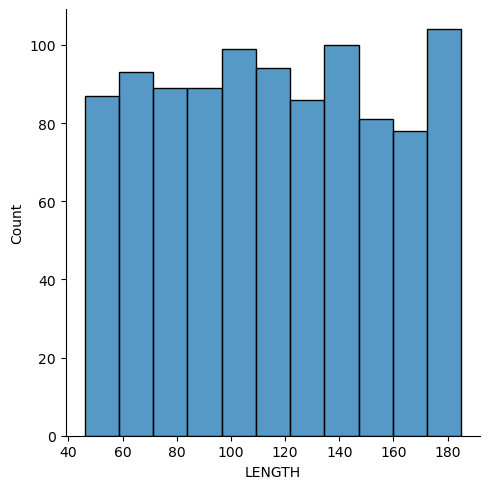

0.03332116668451906

In [12]:
# Exploratory analysis for numerical variables
# Check distributions with distr. plots and calculate skewness to understand how frequency values are distrib.

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.displot(film_data_final['LENGTH'])
plt.show()

film_data_final['LENGTH'].skew()

/Users/lucia/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


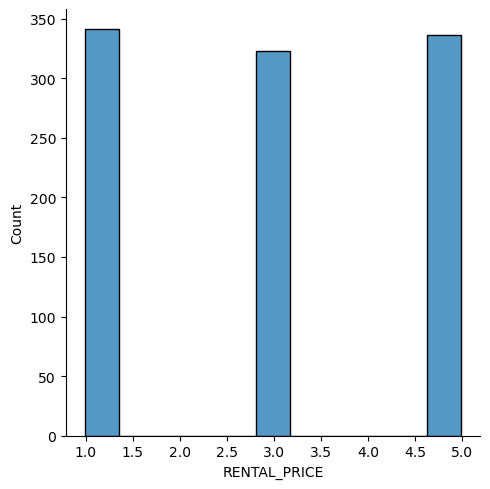

0.009268316666849165

In [13]:
sns.displot(film_data_final['RENTAL_PRICE'])
plt.show()

film_data_final['RENTAL_PRICE'].skew()

/Users/lucia/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


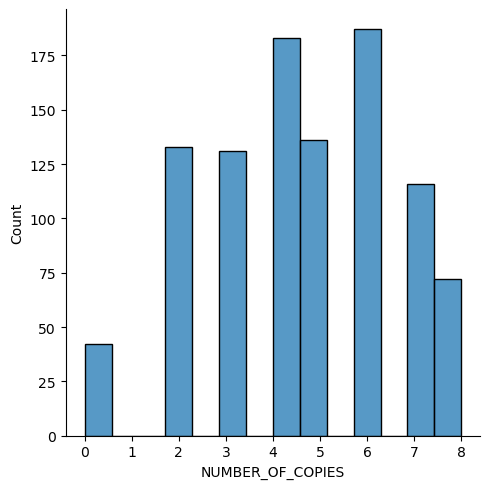

-0.2206642640852815

In [14]:
sns.displot(film_data_final['NUMBER_OF_COPIES'])
plt.show()

film_data_final['NUMBER_OF_COPIES'].skew()

/Users/lucia/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


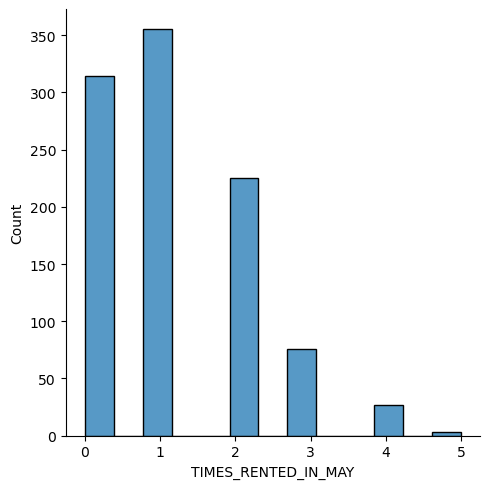

0.7855572683560091

In [15]:
sns.displot(film_data_final['TIMES_RENTED_IN_MAY'])
plt.show()

film_data_final['TIMES_RENTED_IN_MAY'].skew()

In [16]:
# The distribution for the variables LENGTH, RENTAL_PRICE and NUMBER_OF_COPIES seems to be symmetric.
# For TIMES_RENTED_IN_MAY there's a moderate skewness (0.78). I tried to apply logarithmic transformation
# but it didn't work because 1) I have zero values and 2) when I tried to apply a small constant to
# np.log() - to avoid the zero values - it didn't improve the skewness. 
# Because of this (and the skewness being inside the -1, 1 threshold), I will leave it as it is.

# I will also check for multicollinearity among the numerical variables

numerical_columns = film_data_final[['LENGTH','RENTAL_PRICE','NUMBER_OF_COPIES','TIMES_RENTED_IN_MAY']]
correlation_matrix = numerical_columns.corr()
correlation_matrix

,LENGTH,RENTAL_PRICE,NUMBER_OF_COPIES,TIMES_RENTED_IN_MAY
LENGTH,1.000000,0.029789,-0.019243,-0.007575
RENTAL_PRICE,0.029789,1.000000,-0.040384,-0.032559
NUMBER_OF_COPIES,-0.019243,-0.040384,1.000000,0.444436
TIMES_RENTED_IN_MAY,-0.007575,-0.032559,0.444436,1.000000


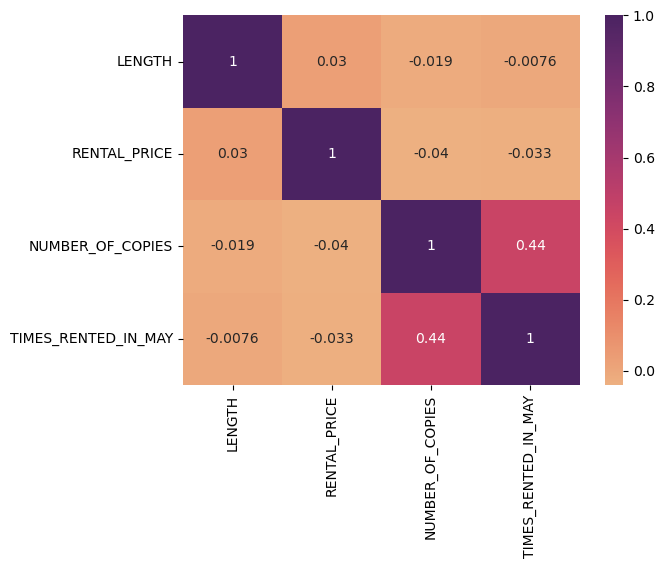

In [17]:
# Let's create a heatmap in order to visualize the correlations in a better way

cmap = sns.color_palette("flare", as_cmap=True)
sns.heatmap((correlation_matrix), annot=True, cmap=cmap)
plt.show()

# From the correlation matrix, we can see that there's no multicollinearity between numerical variables.
# Therefore, we won't need to drop any columns.

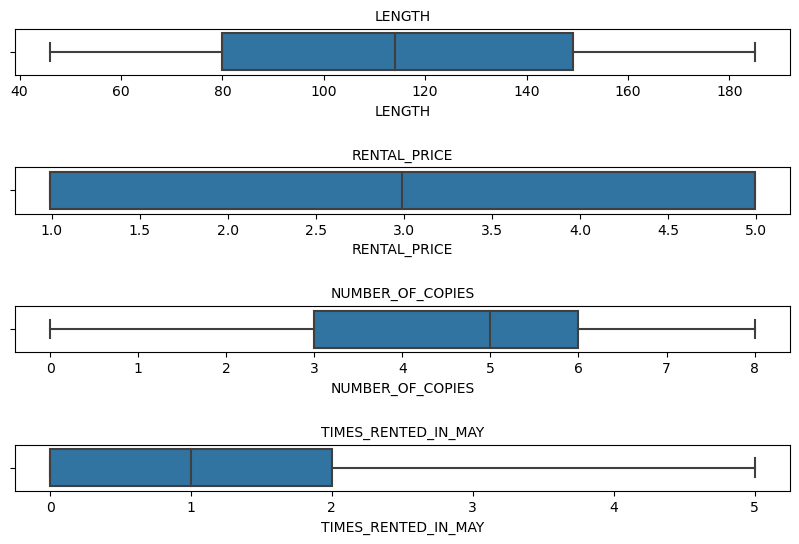

In [18]:
# Even if we don't have heavily skewed distributions and we don't have multicollinearity, we still need
# to check if we have outliers because they might affect our model.

fig, axes = plt.subplots(4, 1, figsize=(10, 6))

for value, col in enumerate(numerical_columns):
    sns.boxplot(x=numerical_columns[col], ax=axes[value])
    axes[value].set_title(col, fontsize=10) 

plt.subplots_adjust(hspace=2)      
    
plt.show()

# From the boxplots below, we can see that there are no outliers in our data so we can continue we the analysis

<Axes: xlabel='count', ylabel='CATEGORY'>

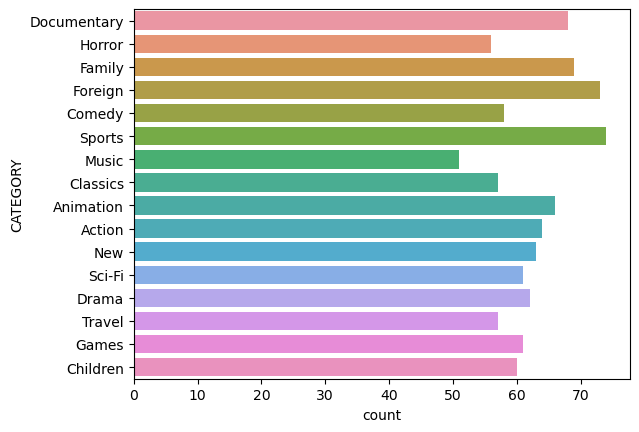

In [19]:
# Check for frequency counts in categorical variables

sns.countplot(data=film_data_final, y="CATEGORY")

# There are many film categories and the frequency counts for them are between 50 and 70.
# From my point of view, there's no signficant imbalance data in this column.

In [20]:
# Split X and y

y_value = film_data_final['RENTED_IN_MAY']
X_value = film_data_final.drop(['RENTED_IN_MAY'], axis=1)

In [21]:
# Split data into train and test set for both X_value and y_value

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_value, y_value, test_size = 0.2, random_state = 69)

# This retrieves a numpy array. Therefore, we need to create dataframes for our X_train and X_test sets

In [22]:
# Create dataframes for X_train and X_test

X_train_df = pd.DataFrame(X_train, columns = X_value.columns).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test, columns = X_value.columns).reset_index(drop=True)

In [23]:
# Split X_train_df and X_test_df into numerical and categorical

import numpy as np

X_train_num = X_train_df.select_dtypes(include = np.number)
X_test_num = X_test_df.select_dtypes(include = np.number)

X_train_cat = X_train_df.select_dtypes(include = object)
X_test_cat = X_test_df.select_dtypes(include = object)


In [24]:
# Create dataframes for these sets

X_train_num_df = pd.DataFrame(X_train_num).reset_index(drop=True)
X_test_num_df = pd.DataFrame(X_test_num).reset_index(drop=True)

X_train_cat_df = pd.DataFrame(X_train_cat).reset_index(drop=True)
X_test_cat_df = pd.DataFrame(X_test_cat).reset_index(drop=True)

In [31]:
# Display dataframes

#display(X_train_num_df)
#display(X_test_num_df)
#display(X_train_cat_df)
display(X_test_cat_df)

# All dataframes were reviewed and they were created in the right way

,CATEGORY
0,Family
1,Comedy
2,Animation
3,Sports
4,Action
...,...
195,Sports
196,Children
197,Animation
198,Comedy


In [26]:
# Transform numerical data with scalers
# Even if it's not mandatory in this case, we will store the transformer

import pickle
import os
from sklearn.preprocessing import MinMaxScaler

scaler_num = MinMaxScaler() # Define Scaler

scaler_num.fit(X_train_num_df) # Train set

# Store transformer

path = "transformers/"
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created!")
    
scaler_file_name = "min_max_scaler.pkl"
with open(path + scaler_file_name, "wb") as file:
    pickle.dump(scaler_num, file)
    
# Apply transformer to both train and test num sets in order for the ranges to be similar

X_train_num_scaled = scaler_num.transform(X_train_num_df) # This creates a numpy array
X_test_num_scaled = scaler_num.transform(X_test_num_df) # This creates a numpy array

In [27]:
# Create dataframes

X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns = X_train_num_df.columns).reset_index(drop=True)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns = X_test_num_df.columns).reset_index(drop=True)

In [28]:
# Display dataframes

#display(X_train_num_scaled_df)
display(X_test_num_scaled_df)

,LENGTH,RENTAL_PRICE,NUMBER_OF_COPIES,TIMES_RENTED_IN_MAY
0,0.043165,1.0,0.500,0.0
1,0.028777,1.0,1.000,0.6
2,0.417266,1.0,0.875,0.2
3,0.100719,0.5,0.750,0.2
4,0.237410,1.0,0.375,0.4
...,...,...,...,...
195,0.834532,1.0,1.000,0.8
196,0.762590,1.0,0.000,0.0
197,0.136691,0.0,0.625,0.2
198,0.733813,0.0,0.875,0.4


In [32]:
# Transform categorical data with OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

encoder_cat = OneHotEncoder(sparse_output=False) # Define Scaler

encoder_cat.fit(X_train_cat_df) # Train set

# Store encoder

path = "encoders/"
isExist - os.path.exists(path)
if not isExist:
    os.makedirs(path)
    print("The new directory is created!")
    
encoder_cat_file_name = "encoder_cat.pkl"
with open(path + encoder_cat_file_name, "wb") as file:
    pickle.dump(encoder_cat, file)
    
# Apply encoder to both train and test sets

X_train_cat_encoded = encoder_cat.transform(X_train_cat_df) # This retrieves a numpy array
X_test_cat_encoded = encoder_cat.transform(X_test_cat_df) # This retrieves a numpy array

column_cat = encoder_cat.get_feature_names_out(['CATEGORY'])

In [33]:
# Create dataframes

X_train_cat_encoded_df = pd.DataFrame(X_train_cat_encoded, columns = column_cat).reset_index(drop=True)
X_test_cat_encoded_df = pd.DataFrame(X_test_cat_encoded, columns = column_cat).reset_index(drop=True)

In [35]:
# Display dataframes

#display(X_train_cat_encoded_df)
display(X_test_cat_encoded_df)

,CATEGORY_Action,CATEGORY_Animation,CATEGORY_Children,CATEGORY_Classics,CATEGORY_Comedy,CATEGORY_Documentary,CATEGORY_Drama,CATEGORY_Family,CATEGORY_Foreign,CATEGORY_Games,CATEGORY_Horror,CATEGORY_Music,CATEGORY_New,CATEGORY_Sci-Fi,CATEGORY_Sports,CATEGORY_Travel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
196,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Concat numerical and categorical dataframes

train_df_concat = pd.concat([X_train_num_scaled_df, X_train_cat_encoded_df], axis=1)
test_df_concat = pd.concat([X_test_num_scaled_df, X_test_cat_encoded_df], axis=1)

In [38]:
# Display dataframes

#display(train_df_concat)
display(test_df_concat)

,LENGTH,RENTAL_PRICE,NUMBER_OF_COPIES,TIMES_RENTED_IN_MAY,CATEGORY_Action,CATEGORY_Animation,CATEGORY_Children,CATEGORY_Classics,CATEGORY_Comedy,CATEGORY_Documentary,CATEGORY_Drama,CATEGORY_Family,CATEGORY_Foreign,CATEGORY_Games,CATEGORY_Horror,CATEGORY_Music,CATEGORY_New,CATEGORY_Sci-Fi,CATEGORY_Sports,CATEGORY_Travel
0,0.043165,1.0,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.028777,1.0,1.000,0.6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.417266,1.0,0.875,0.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.100719,0.5,0.750,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.237410,1.0,0.375,0.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.834532,1.0,1.000,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
196,0.762590,1.0,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.136691,0.0,0.625,0.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.733813,0.0,0.875,0.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# In this case, there's no need to use transform the concatenated dataframe because all values are in 
# the same range already

5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [45]:
# Import model and train our set with it

from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state = 0, solver = 'lbfgs', multi_class = 'multinomial')

classification.fit(train_df_concat, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

In [46]:
# Making predictions

y_test_pred = classification.predict(test_df_concat)
print(y_test_pred) # This prints 200 values (the amount of rows in our test set)

[False  True  True  True  True False False  True False  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True False False False  True  True  True  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True False  True
  True  True  True False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True False  True False  True False False False False False  True
  True False  True False  True False False False  True  True  True  True
 False  True False  True False  True  True False  True False  True  True
 False  True  True False  True  True  True  True  True  True False  True
  True  True  True  True  True False  True  True  True False  True False
  True  True  True  True  True False  True  True  True False False  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False  True  True Fa

In [47]:
# Create confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix(y_test, y_test_pred) # The confusion matrix is created with the real values and the predicted ones

array([[ 53,   0],
       [  0, 147]])

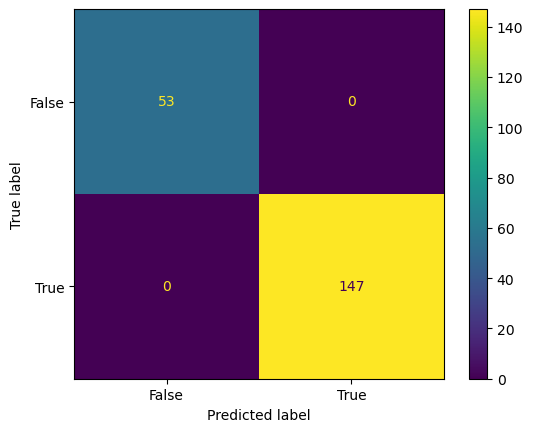

In [48]:
# Plot the confusion matrix

cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(cm_test, display_labels = classification.classes_)
disp.plot()
plt.show()

In [51]:
# It's always important to calculate kappa and generate a classification report in order to have more
# insights about our data. In this case, we are not gonna do it because the model is 100% accurate for the
# variables that were selected for the analysis.
# This model doesn't need to be improved but we can always do a new analysis and add more variables to 
# it (for instance, special features) in order to understand how its performance is modified - or not.